In [ ]:
# Basic data manipulation
import pandas as pd
import numpy as np
import random

# Visualization
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer

# Classifiers
from catboost import CatBoostClassifier

# Additional encoders
import category_encoders as ce

# Stats
import scipy.stats as stats

# Dimensionality reduction
from sklearn.decomposition import (
    PCA,
    KernelPCA, 
    FastICA,
    TruncatedSVD
)

### First and foremost, merge two dbs into one

In [ ]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

In [ ]:
test_identity = pd.read_csv("data/test_identity.csv")
test_transaction = pd.read_csv("data/test_transaction.csv")
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

In [ ]:
test.columns = test.columns.str.replace('-', '_')

### Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Identifying the target variable distribution and missing values for features

In [ ]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [ ]:
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

In [ ]:
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


In [ ]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

### Find truly categorical values

Screen resolution values are true numerical values, while all other features are categorical in nature

In [ ]:
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [ ]:
test[['Screen_Width', 'Screen_Height']] = test['id_33'].str.split('x', expand=True).astype(float)
test = test.drop(columns=['id_33'])

In [ ]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if (unique_vals < unique_threshold) and (col != "isFraud"):
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

### Imputing nulls

Not using standard imputation:
1. Placed zero values as indicator for missing values where feature values no zero values anywhere else
2. Added 'missing' instead of null for categorical values to keep all the columns

In [ ]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys())))
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using zeros as indicator
num_imputer = SimpleImputer(strategy='constant', fill_value=0)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

In [ ]:
test[num_cols] = num_imputer.transform(test[num_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])
print("Total missing values after imputation:", train.isnull().sum().sum())

### Data encoding

In [ ]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

### Encoding categorical features

Splitting train and test asap

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Using novel thing: WOE encoder to compensate for an enormous dimentionality for SVC

In [ ]:
encoder_high = ce.WOEEncoder(cols=cat_cols)
X_train_encoded_cat = encoder_high.fit_transform(X_train[cat_cols], y_train)
X_test_encoded_cat = encoder_high.transform(X_test[cat_cols])

In [ ]:
test_encoded_cat = encoder_high.transform(test[cat_cols])

### Data normalization

Scale data to remove any disrepancies in SVC

In [ ]:
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[num_cols])
X_test_scaled_num = scaler.transform(X_test[num_cols])

In [ ]:
test_scaled_num = scaler.transform(test[num_cols])

In [ ]:
X_train_scaled = pd.DataFrame(np.hstack([X_train_encoded_cat.values, X_train_scaled_num]), columns=cat_cols + num_cols)
X_test_scaled = pd.DataFrame(np.hstack([X_test_encoded_cat.values, X_test_scaled_num]), columns=cat_cols + num_cols)

In [ ]:
test_scaled = pd.DataFrame(np.hstack([test_encoded_cat.values, test_scaled_num]), columns=cat_cols + num_cols)

In [ ]:
print("Encoded training set shape:", X_train_scaled.shape)
print("Encoded test set shape:", X_test_scaled.shape)

In [ ]:
print("Encoded final test set shape:", test_scaled.shape)

In [ ]:
X_train_scaled.head()

In [ ]:
test_scaled = pd.DataFrame(np.hstack([test[["TransactionID"]], test_scaled]), columns=["TransactionID"] + list(test_scaled.columns))
test_scaled.head()

### Save data

In [ ]:
X_train_scaled.to_csv("data/preprocessed_train.csv", index=False)
X_test_scaled.to_csv("data/preprocessed_test.csv", index=False)

y_train.to_csv("data/y_train.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

In [ ]:
test_scaled.to_csv("data/test_for_model_eval.csv", index=False)

### Baseline catboost

Download processed data

In [ ]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_test_scaled = pd.read_csv("data/preprocessed_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

Accounting for severe class imbalance

In [ ]:
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

PCA

In [ ]:
pca = PCA(n_components=30)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

Independent Component Analysis (ICA)

In [ ]:
ica = FastICA(n_components=30, random_state=42)
X_train_scaled = ica.fit_transform(X_train_scaled)
X_test_scaled = ica.transform(X_test_scaled)

Truncated SVD

In [ ]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_scaled = svd.fit_transform(X_train_scaled)
X_test_scaled = svd.transform(X_test_scaled)

Train baseline model

In [ ]:
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_scaled, y_train_flat)
y_pred_cat = model_cat.predict(X_test_scaled)

print("CatBoost Training Accuracy:", accuracy_score(y_test_flat, y_pred_cat))

#### With all features:
0:	learn: 0.6515508	total: 127ms	remaining: 1m 3s 

100:	learn: 0.3743155	total: 13.5s	remaining: 53.4s

200:	learn: 0.3282363	total: 26.9s	remaining: 40s

300:	learn: 0.2981647	total: 40s	remaining: 26.5s

400:	learn: 0.2745897	total: 53.3s	remaining: 13.2s

499:	learn: 0.2570046	total: 1m 6s	remaining: 0us

CatBoost Training Accuracy: **0.9161614793240085**

#### With PCA:
0:	learn: 0.6556789	total: 83.4ms	remaining: 41.6s

100:	learn: 0.4566328	total: 2.05s	remaining: 8.11s

200:	learn: 0.4297046	total: 4.63s	remaining: 6.88s

300:	learn: 0.4090670	total: 7.42s	remaining: 4.9s

400:	learn: 0.3936705	total: 9.96s	remaining: 2.46s

499:	learn: 0.3800877	total: 12.6s	remaining: 0us

CatBoost Training Accuracy: **0.8490026077827073**

#### With ICA:
0:	learn: 0.6656583	total: 22ms	remaining: 11s
]
100:	learn: 0.4502845	total: 2.46s	remaining: 9.73s

200:	learn: 0.4190396	total: 7.02s	remaining: 10.4s

300:	learn: 0.3956015	total: 10.4s	remaining: 6.87s

400:	learn: 0.3764075	total: 13.7s	remaining: 3.39s

499:	learn: 0.3601961	total: 17s	remaining: 0us

CatBoost Training Accuracy: **0.8604751583296644**

#### With SVD:
0:	learn: 0.6564134	total: 23.7ms	remaining: 11.8s

100:	learn: 0.4559546	total: 1.94s	remaining: 7.68s

200:	learn: 0.4280927	total: 3.91s	remaining: 5.81s

300:	learn: 0.4068786	total: 5.88s	remaining: 3.89s

400:	learn: 0.3903511	total: 7.88s	remaining: 1.95s

499:	learn: 0.3767146	total: 9.87s	remaining: 0us

CatBoost Training Accuracy: **0.8494090154773597**

### GA for input features subset selection

In [ ]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_test_scaled = pd.read_csv("data/preprocessed_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

In [ ]:
def run_genetic_algorithm(X_data, y_data, population_size=30, n_generations=30, subset_size=30):
    n_features = X_data.shape[1]
    feature_names = X_data.columns.tolist()
    
    # Initialize population - each individual is a sorted list of feature indices
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size)
        subset.sort()
        population.append(subset)
    
    def fitness(individual):
        X_subset = X_data.iloc[:, individual]
        
        # Manual train/test split instead of cross-validation
        X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(
            X_subset, y_data, test_size=0.2, random_state=42, stratify=y_data
        )
        
        try:
            model = CatBoostClassifier(
                iterations=100,  # Reduce from 500 to speed up GA
                learning_rate=0.1,
                depth=6,
                class_weights=class_weights_dict,
                random_seed=42,
                verbose=0        # Turn off verbosity completely            
            )
            
            # Use a simple fit instead of cross_val_score
            model.fit(X_train_subset, y_train_subset, 
                     eval_set=(X_val_subset, y_val_subset),
                     early_stopping_rounds=20,
                     verbose=False)
            
            # Get validation accuracy
            accuracy = accuracy_score(y_val_subset, model.predict(X_val_subset))
            print(f"Feature subset evaluated: accuracy = {accuracy:.4f}")
            return accuracy
            
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return 0.0  # Return worst fitness on error
    
    # Creates a child by merging features from both parents and selecting a random subset
    def crossover(p1, p2, subset_size):
        combined = list(set(p1) | set(p2))  # Union of features
        if len(combined) > subset_size:
            child = sorted(random.sample(combined, subset_size))  # Ensure correct size
        else:
            child = sorted(combined)  # Keep all if below subset_size
        return child

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(individual, n_features, subset_size):
        if random.random() < 0.1:  # 10% chance of mutation
            i = random.randrange(subset_size)
            available_features = set(range(n_features)) - set(individual)  # Exclude existing features
            if available_features:  
                new_feature = random.choice(list(available_features))
                individual[i] = new_feature
                individual.sort()
        return individual


    for i in range(n_generations):
        print(f"\nGeneration {i+1}/{n_generations}")
        # Evaluate fitness of population
        print("Evaluating fitness for each individual:")
        scored_population = []
        for idx, ind in enumerate(population):
            fitness_score = fitness(ind)
            scored_population.append((fitness_score, ind))
            print(f"Individual {idx+1}/{len(population)}: Fitness = {fitness_score:.4f}")
        
        scored_population.sort(key=lambda x: x[0], reverse=True)
        best_subset = scored_population[0][1]
        print(f"\nBest fitness in generation {i+1}: {scored_population[0][0]:.4f}")
        print("Current best features:", [feature_names[i] for i in best_subset])
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        print("Creating new population...")
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            print("Generating new individual...")
            
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
            
            print("New individual created! Happy birthday!")
        population = new_pop
        print("Current best:", max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1])
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    print("\nFinal Selected Features:")
    for idx, feature_idx in enumerate(best, 1):
        print(f"{idx}. {feature_names[feature_idx]}")
    print(f"\nTotal features selected: {len(best)}")
    return best

best_features = run_genetic_algorithm(X_train_scaled, y_train)
X_train_ga = X_train_scaled.iloc[:, best_features]
X_test_ga = X_test_scaled.iloc[:, best_features]
model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=100
        )
model.fit(X_train_ga, y_train)
y_pred = model.predict(X_test_ga)
print("Final features:", best_features)
print("Model accuracy with selected features:", accuracy_score(y_test, y_pred))

Total features selected: 30
0:	learn: 0.6638991	total: 24.9ms	remaining: 12.4s
100:	learn: 0.4927042	total: 2.67s	remaining: 10.5s
200:	learn: 0.4564309	total: 5.4s	remaining: 8.04s
300:	learn: 0.4329192	total: 8.12s	remaining: 5.37s
400:	learn: 0.4150281	total: 10.8s	remaining: 2.67s
499:	learn: 0.3979050	total: 13.6s	remaining: 0us
Final features: [16, 36, 43, 63, 71, 99, 104, 138, 153, 161, 169, 171, 175, 182, 186, 191, 251, 270, 275, 281, 314, 325, 328, 348, 355, 358, 397, 400, 419, 428]
Model accuracy with selected features: 0.8880177464693332

In [ ]:
# Use GA selected feature indices
best_features = [16, 36, 43, 63, 71, 99, 104, 138, 153, 161, 169, 171, 175, 182, 186, 191, 251, 270, 275, 281, 314, 325, 328, 348, 355, 358, 397, 400, 419, 428]

# Extract data with only selected features from GA
X_train_ga = X_train_scaled.iloc[:, best_features]
X_test_ga = X_test_scaled.iloc[:, best_features]

print(f"Original feature count: {X_train_scaled.shape[1]}")
print(f"GA-selected feature count: {X_train_ga.shape[1]}")
print(f"Training data shape after GA selection: {X_train_ga.shape}")
print(f"Testing data shape after GA selection: {X_test_ga.shape}")

# Display feature names selected by GA
print("\nGA-selected features:")
feature_names = X_train_scaled.columns
selected_feature_names = [feature_names[i] for i in best_features]
for i, feature in enumerate(selected_feature_names, 1):
    print(f"{i}. {feature}")

In [ ]:
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

### PSO and ACO for catboost hyperparameter tuning

In [ ]:
import numpy as np
from pyswarm import pso
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def run_pso_for_catboost_hyperparams(X_train_ga, y_train, X_test_ga, y_test, n_particles=10, n_iterations=5):
    """
    Runs Particle Swarm Optimization (PSO) to find optimal hyperparameters for CatBoost using the provided training and testing data (already filtered by GA features).

    Args:
        X_train_ga: Training features (pandas DataFrame or numpy array) selected by GA.
        y_train: Training target variable.
        X_test_ga: Testing features (pandas DataFrame or numpy array) selected by GA.
        y_test: Testing target variable.
        n_particles: Number of particles in the swarm.
        n_iterations: Number of iterations for PSO.

    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by PSO.
    """
    print(f"Starting PSO with {n_particles} particles and {n_iterations} iterations...")

    # Mapping for categorical parameters (indices):
    grow_policy_map = ['SymmetricTree', 'Depthwise', 'Lossguide']
    bootstrap_type_map = ['Bayesian', 'Bernoulli', 'MVS']
    leaf_estimation_method_map = ['Newton', 'Gradient']
    boosting_type_map = ['Ordered', 'Plain']

    param_bounds_pso = {
        # Key order must match the order in objective_function_pso's params array
        'learning_rate': (0.01, 0.3),             # params[0]
        'depth': (3, 10),                         # params[1] Integer
        'l2_leaf_reg': (1.0, 10.0),               # params[2]
        'iterations': (100, 1000),                # params[3] Integer
        'grow_policy_idx': (0, len(grow_policy_map) - 1), # params[4] Integer index
        'max_leaves': (4, 64),                    # params[5] Integer
        'min_data_in_leaf': (1, 50),              # params[6] Integer
        'random_strength': (0.1, 5.0),            # params[7]
        'bagging_temperature': (0.0, 1.0),        # params[8]
        'bootstrap_type_idx': (0, len(bootstrap_type_map) - 1), # params[9] Integer index
        'subsample': (0.5, 1.0),                  # params[10] Used only if bootstrap_type is not Bayesian
        'rsm': (0.5, 1.0),                        # params[11] aka colsample_bylevel
        'leaf_estimation_method_idx': (0, len(leaf_estimation_method_map) - 1), # params[12] Integer index
        'leaf_estimation_iterations': (1, 10),    # params[13] Integer
        'boosting_type_idx': (0, len(boosting_type_map) - 1), # params[14] Integer index
        'one_hot_max_size': (2, 30),              # params[15] Integer
        'early_stopping_rounds': (10, 50)         # params[16] Integer, used in fit
    }

    # Ordered list of keys corresponding to the parameter order
    param_keys = list(param_bounds_pso.keys())

    # Define the objective function for PSO
    def objective_function_pso(params):
        # --- Parameter Extraction and Mapping ---
        depth = int(round(params[param_keys.index('depth')]))
        iterations = int(round(params[param_keys.index('iterations')]))
        grow_policy_idx = int(round(params[param_keys.index('grow_policy_idx')]))
        max_leaves = int(round(params[param_keys.index('max_leaves')]))
        min_data_in_leaf = int(round(params[param_keys.index('min_data_in_leaf')]))
        bootstrap_type_idx = int(round(params[param_keys.index('bootstrap_type_idx')]))
        leaf_estimation_method_idx = int(round(params[param_keys.index('leaf_estimation_method_idx')]))
        leaf_estimation_iterations = int(round(params[param_keys.index('leaf_estimation_iterations')]))
        boosting_type_idx = int(round(params[param_keys.index('boosting_type_idx')]))
        one_hot_max_size = int(round(params[param_keys.index('one_hot_max_size')]))
        early_stopping_rounds = int(round(params[param_keys.index('early_stopping_rounds')]))
        
        grow_policy = grow_policy_map[grow_policy_idx]
        bootstrap_type = bootstrap_type_map[bootstrap_type_idx]
        leaf_estimation_method = leaf_estimation_method_map[leaf_estimation_method_idx]
        boosting_type = boosting_type_map[boosting_type_idx]
        
        # --- Adjust incompatible parameters ---
        # max_leaves is valid only with Lossguide tree growing. If not Lossguide, do not include max_leaves.
        if grow_policy != "Lossguide":
            max_leaves = None
        # Ordered boosting is supported only for symmetric trees; change to Plain if needed.
        if boosting_type == "Ordered" and grow_policy != "SymmetricTree":
            boosting_type = "Plain"
        
        # --- Build CatBoost Params ---
        cb_params = {
            'learning_rate': params[param_keys.index('learning_rate')],
            'depth': depth,
            'l2_leaf_reg': params[param_keys.index('l2_leaf_reg')],
            'iterations': iterations,
            'grow_policy': grow_policy,
            **({'max_leaves': max_leaves} if max_leaves is not None else {}),
            'min_data_in_leaf': min_data_in_leaf,
            'random_strength': params[param_keys.index('random_strength')],
            'bootstrap_type': bootstrap_type,
            'rsm': params[param_keys.index('rsm')],
            'leaf_estimation_method': leaf_estimation_method,
            'leaf_estimation_iterations': leaf_estimation_iterations,
            'boosting_type': boosting_type,
            'one_hot_max_size': one_hot_max_size,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 0,
            'random_state': 42
        }
        
        # Handle parameter dependencies for bootstrap_type
        if bootstrap_type == 'Bayesian':
            cb_params['bagging_temperature'] = params[param_keys.index('bagging_temperature')]
        elif bootstrap_type in ['Bernoulli', 'MVS']:
            cb_params['subsample'] = params[param_keys.index('subsample')]
        
        # --- Train and Evaluate ---
        model = CatBoostClassifier(**cb_params)
        try:
            model.fit(X_train_ga, y_train,
                      eval_set=(X_test_ga, y_test),
                      early_stopping_rounds=early_stopping_rounds,
                      verbose=0)
            y_pred_proba = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
        except Exception as e:
            print(f"Warning: Exception during model training/evaluation: {e}")
            print(f"Params causing issue: {cb_params}")
            auc = 0.0
        return auc

    # Extract bounds for pyswarm
    lb = [param_bounds_pso[k][0] for k in param_keys]
    ub = [param_bounds_pso[k][1] for k in param_keys]

    # Run PSO
    best_params_pso_vals, best_score_pso = pso(objective_function_pso, lb, ub, swarmsize=n_particles, maxiter=n_iterations)

    # --- Process Results ---
    # Map best_params_pso_vals back to dictionary
    best_params_pso_dict = {}
    for i, key in enumerate(param_keys):
        val = best_params_pso_vals[i]
        if key in ['depth', 'iterations', 'grow_policy_idx', 'max_leaves', 'min_data_in_leaf',
                   'bootstrap_type_idx', 'leaf_estimation_method_idx', 'leaf_estimation_iterations',
                   'boosting_type_idx', 'one_hot_max_size', 'early_stopping_rounds']:
            best_params_pso_dict[key] = int(round(val))
        else:
            best_params_pso_dict[key] = val

    # Map indices back for categorical features
    best_params_pso_dict['grow_policy'] = grow_policy_map[best_params_pso_dict['grow_policy_idx']]
    best_params_pso_dict['bootstrap_type'] = bootstrap_type_map[best_params_pso_dict['bootstrap_type_idx']]
    best_params_pso_dict['leaf_estimation_method'] = leaf_estimation_method_map[best_params_pso_dict['leaf_estimation_method_idx']]
    best_params_pso_dict['boosting_type'] = boosting_type_map[best_params_pso_dict['boosting_type_idx']]

    # Store the early stopping rounds value separately as it's used in fit, not constructor
    best_early_stopping_rounds = best_params_pso_dict['early_stopping_rounds']

    # Remove index keys and early stopping rounds from the main dict
    keys_to_remove = ['grow_policy_idx', 'bootstrap_type_idx', 'leaf_estimation_method_idx', 'boosting_type_idx', 'early_stopping_rounds']
    for key in keys_to_remove:
       best_params_pso_dict.pop(key, None)

    # Handle conditional subsample: Remove if not needed, ensure exists if needed
    if best_params_pso_dict['bootstrap_type'] not in ['Bernoulli', 'MVS']:
        best_params_pso_dict.pop('subsample', None)
    elif 'subsample' not in best_params_pso_dict:
         # If needed but missing (e.g., boundary issue), assign a default or average
         best_params_pso_dict['subsample'] = np.mean(param_bounds_pso['subsample'])

    print("-" * 30)
    print("PSO Finished.")
    print(f"Best AUC score found by PSO: {best_score_pso:.6f}")
    print("Best CatBoost Parameters (excluding early_stopping_rounds):")
    for key, val in best_params_pso_dict.items():
        print(f"  {key}: {val}")
    print(f"Best early_stopping_rounds: {best_early_stopping_rounds}")
    print("-" * 30)

    # Add early stopping rounds back for potential direct use later if needed
    best_params_pso_dict_final = best_params_pso_dict.copy()
    best_params_pso_dict_final['early_stopping_rounds'] = best_early_stopping_rounds

    return best_params_pso_dict_final, best_score_pso

In [ ]:
import numpy as np
import random
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split # Optional

class ACO_HyperparameterOptimizer:
    """
    Ant Colony Optimization for Hyperparameter Tuning.

    Attributes:
        param_grid (dict): Dictionary where keys are hyperparameter names
                           and values are lists of discrete values to explore.
        objective_function (callable): A function that takes a dictionary of
                                      hyperparameters and returns a score to maximize.
        n_ants (int): Number of ants (solutions generated per iteration).
        n_iterations (int): Number of optimization iterations.
        alpha (float): Pheromone influence factor.
        beta (float): Heuristic influence factor (currently unused, set to 1).
        rho (float): Pheromone evaporation rate (0 < rho <= 1).
        Q (float): Pheromone deposit constant.
        min_pheromone (float): Minimum pheromone level to prevent stagnation.
        pheromones (dict): Nested dictionary storing pheromone levels for each parameter choice.
        global_best_score (float): Best score found across all iterations.
        global_best_params (dict): Hyperparameter set corresponding to the best score.
    """
    def __init__(self, param_grid, objective_function, n_ants, n_iterations,
                 alpha=1.0, beta=1.0, rho=0.1, Q=1.0, min_pheromone=0.01):
        """
        Initializes the ACO optimizer.
        """
        self.param_grid = param_grid
        self.objective_function = objective_function
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta  # Heuristic factor (often kept simple for HP tuning)
        self.rho = rho    # Evaporation rate
        self.Q = Q        # Pheromone deposit constant
        self.min_pheromone = min_pheromone # Minimum pheromone level

        self.param_names = list(self.param_grid.keys())
        self.pheromones = self._initialize_pheromones()

        self.global_best_score = -np.inf
        self.global_best_params = None

    def _initialize_pheromones(self):
        """
        Initializes pheromone trails with a constant value for all parameter choices.
        """
        pheromones = {}
        initial_pheromone = 1.0 # Start with a neutral pheromone level
        for param, values in self.param_grid.items():
            pheromones[param] = {value: initial_pheromone for value in values}
        return pheromones

    def _select_next_node(self, param_name):
        """
        Selects a value for a given parameter based on pheromone levels.
        Uses a probabilistic choice mechanism influenced by pheromones.
        """
        pheromone_values = self.pheromones[param_name]
        choices = list(pheromone_values.keys())
        current_pheromones = np.array([pheromone_values[choice] for choice in choices])

        # Heuristic information (tau^alpha * eta^beta)
        # For hyperparameter tuning, heuristic info (eta) is often uniform (beta=0 or eta=1)
        # unless prior knowledge exists. We'll use beta=1 but eta=1 implicitly.
        selection_probs = current_pheromones ** self.alpha # * (heuristic ** self.beta)

        # Handle potential division by zero if all probs are zero (e.g., early stage)
        prob_sum = np.sum(selection_probs)
        if prob_sum == 0:
            # If sum is zero, choose uniformly
            selection_probs = np.ones(len(choices)) / len(choices)
        else:
            selection_probs = selection_probs / prob_sum

        # Choose a value based on calculated probabilities
        chosen_value = np.random.choice(choices, p=selection_probs)
        return chosen_value

    def _construct_solution(self):
        """
        Constructs a complete hyperparameter set (solution) for a single ant.
        """
        solution = {}
        for param_name in self.param_names:
            solution[param_name] = self._select_next_node(param_name)
        return solution

    def _update_pheromones(self, ant_solutions, ant_scores):
        """
        Updates pheromone levels based on evaporation and deposition from ant solutions.
        """
        # 1. Evaporation
        for param, values in self.pheromones.items():
            for value in values:
                self.pheromones[param][value] *= (1.0 - self.rho)
                # Enforce minimum pheromone level
                self.pheromones[param][value] = max(self.pheromones[param][value], self.min_pheromone)

        # 2. Deposition
        # Deposit pheromone based on the quality of solutions found
        # More sophisticated strategies exist (e.g., only best ant deposits, elitism)
        # Here, all ants deposit based on their score
        for i in range(self.n_ants):
            solution = ant_solutions[i]
            score = ant_scores[i]

            # Normalize score or use directly? Depends on score range.
            # Assuming score is something like AUC (0 to 1), direct use might be okay.
            # We use Q as a scaling factor.
            if score > -np.inf: # Only deposit if the evaluation was successful
                delta_pheromone = self.Q * score # Simple proportional deposit

                for param_name, value in solution.items():
                    # Check if the parameter/value exists (it should)
                    if param_name in self.pheromones and value in self.pheromones[param_name]:
                        self.pheromones[param_name][value] += delta_pheromone
                    else:
                        # This case should ideally not happen if grid is consistent
                         print(f"Warning: Parameter '{param_name}' or value '{value}' not found in pheromone trails during deposition.")


    def run(self):
        """
        Executes the ACO optimization process.
        """
        print(f"Starting ACO: {self.n_iterations} iterations, {self.n_ants} ants/iteration.")
        print(f"Params: alpha={self.alpha}, beta={self.beta}, rho={self.rho}, Q={self.Q}")

        for iteration in range(self.n_iterations):
            ant_solutions = []
            ant_scores = []

            # Generate solutions for all ants
            for ant in range(self.n_ants):
                solution = self._construct_solution()
                try:
                    score = self.objective_function(solution.copy()) # Pass a copy
                    if score is None or not np.isfinite(score):
                       # Handle cases where objective function fails or returns invalid score
                       print(f"Warning: Objective function returned invalid score ({score}) for params: {solution}. Assigning low score.")
                       score = -np.inf
                except Exception as e:
                    print(f"Error evaluating solution: {solution}")
                    print(f"Exception: {e}")
                    score = -np.inf # Penalize errors heavily

                ant_solutions.append(solution)
                ant_scores.append(score)

                # Update global best if current ant is better
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_params = solution
                    print(f"Iteration {iteration+1}, Ant {ant+1}: New best score! -> {self.global_best_score:.6f}")

            # Update pheromone trails based on the iteration's results
            self._update_pheromones(ant_solutions, ant_scores)

            avg_score = np.mean([s for s in ant_scores if s > -np.inf]) if any(s > -np.inf for s in ant_scores) else -np.inf
            print(f"Iteration {iteration+1}/{self.n_iterations} finished. Avg Score: {avg_score:.6f}. Best Score so far: {self.global_best_score:.6f}")

        print("-" * 30)
        print("ACO Finished.")
        if self.global_best_params:
            print(f"Best score found: {self.global_best_score:.6f}")
            print("Best parameters found:")
            for param, value in self.global_best_params.items():
                print(f"  {param}: {value}")
        else:
            print("ACO did not find a valid solution.")
        print("-" * 30)

        return self.global_best_params, self.global_best_score

In [ ]:
def run_aco_for_catboost_hyperparams(X_train_ga, y_train, X_test_ga, y_test,
                                     n_ants=10, n_iterations=5,
                                     alpha=1.0, beta=1.0, rho=0.1, Q=1.0): # Add ACO params
    """
    Runs Ant Colony Optimization (ACO) using the implemented class to find
    optimal hyperparameters for CatBoost using the provided GA-filtered data.

    Args:
        X_train_ga: Training features (pandas DataFrame or numpy array) selected by GA.
        y_train: Training target variable.
        X_test_ga: Testing features (pandas DataFrame or numpy array) selected by GA.
        y_test: Testing target variable.
        n_ants (int): Number of ants (solutions per iteration).
        n_iterations (int): Number of iterations for ACO.
        alpha (float): Pheromone influence factor for ACO.
        beta (float): Heuristic influence factor for ACO (currently unused).
        rho (float): Pheromone evaporation rate for ACO.
        Q (float): Pheromone deposit constant for ACO.


    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by ACO.
    """

    # --- Define Parameter Grid (same as before) ---
    param_grid_aco = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1.0, 3.0, 5.0, 7.0, 10.0],
        'iterations': [100, 200, 300, 500, 700, 1000],
        'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
        'max_leaves': [8, 16, 32, 64],
        'min_data_in_leaf': [1, 5, 10, 20, 50],
        'random_strength': [0.1, 0.5, 1.0, 2.0, 5.0],
        'bagging_temperature': [0.0, 0.2, 0.5, 0.8, 1.0],
        'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Used only if bootstrap_type is not Bayesian
        'rsm': [0.6, 0.7, 0.8, 0.9, 1.0], # colsample_bylevel
        'leaf_estimation_method': ['Newton', 'Gradient'],
        'leaf_estimation_iterations': [1, 3, 5, 10],
        'boosting_type': ['Ordered', 'Plain'],
        'one_hot_max_size': [2, 10, 20, 30],
        'early_stopping_rounds': [10, 20, 30, 50] # Used in fit
    }

    # --- Define Objective Function (same as before) ---
    def objective_function_aco(params):
        # params is a dictionary constructed by the ACO framework for one ant
        cb_params = params.copy()
        early_stopping_rounds = cb_params.pop('early_stopping_rounds', 30) # Default if missing

        # Handle parameter dependencies
        bootstrap_type = cb_params.get('bootstrap_type', 'Bayesian')
        if bootstrap_type == 'Bayesian':
            # Keep bagging_temperature only for Bayesian bootstrap
            if 'bagging_temperature' not in cb_params:
                cb_params['bagging_temperature'] = 0.5  # default value
            if 'subsample' in cb_params:
                cb_params.pop('subsample')
        else:
            # For Bernoulli and MVS, use subsample and remove bagging_temperature
            if 'bagging_temperature' in cb_params:
                cb_params.pop('bagging_temperature')
            if 'subsample' not in cb_params:
                cb_params['subsample'] = 0.8  # default value

        cb_params.update({
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 0,
            'random_state': 42
        })

        model = CatBoostClassifier(**cb_params)
        try:
            model.fit(X_train_ga, y_train,
                    eval_set=(X_test_ga, y_test),
                    early_stopping_rounds=early_stopping_rounds,
                    verbose=0)
            y_pred_proba = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            if not np.isfinite(auc):
                auc = 0.0
        except Exception as e:
            auc = 0.0

        return auc

    # --- Instantiate and Run ACO ---
    aco_optimizer = ACO_HyperparameterOptimizer(
        param_grid=param_grid_aco,
        objective_function=objective_function_aco,
        n_ants=n_ants,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=beta,
        rho=rho,
        Q=Q
    )

    best_params_aco, best_score_aco = aco_optimizer.run() # Run the optimization

    # --- Process and Return Results ---
    # The run method already prints results. We just return them.
    # Note: best_params_aco will include 'early_stopping_rounds' if found.
    return best_params_aco, best_score_aco

### Run PSO and ACO optimizations using GA-selected features

Now we'll run both PSO and ACO optimization algorithms on the same feature set selected by GA. This ensures fair comparison between optimization methods while benefiting from the dimension reduction provided by GA.

In [ ]:
# Run PSO optimization on GA-selected features
print("Starting PSO optimization on GA-selected features...")
best_pso_params, best_pso_score = run_pso_for_catboost_hyperparams(
    X_train_ga, y_train, X_test_ga, y_test,
    n_particles=10,
    n_iterations=20
)

# Fix incompatible parameters in PSO results
if 'grow_policy' in best_pso_params and best_pso_params['grow_policy'] != 'Lossguide' and 'boosting_type' in best_pso_params and best_pso_params['boosting_type'] == 'Ordered':
    print("Warning: Ordered boosting not supported for non-symmetric trees. Changing boosting_type to 'Plain'")
    best_pso_params['boosting_type'] = 'Plain'

# Fix bootstrap type and bagging temperature incompatibility
if 'bootstrap_type' in best_pso_params and best_pso_params['bootstrap_type'] != 'Bayesian' and 'bagging_temperature' in best_pso_params:
    print("Warning: Bagging temperature only available for Bayesian bootstrap. Removing parameter.")
    best_pso_params.pop('bagging_temperature', None)

# Run ACO optimization on the same GA-selected features
print("\nStarting ACO optimization on GA-selected features...")
best_aco_params, best_aco_score = run_aco_for_catboost_hyperparams(
    X_train_ga, y_train, X_test_ga, y_test,
    n_ants=10,
    n_iterations=20,
    alpha=1.0,
    beta=1.0,
    rho=0.1,
    Q=1.0
)

PSO Finished.
Best AUC score found by PSO: 0.706496
Best CatBoost Parameters (excluding early_stopping_rounds):
  learning_rate: 0.01
  depth: 3
  l2_leaf_reg: 2.89086081049249
  iterations: 100
  max_leaves: 34
  min_data_in_leaf: 42
  random_strength: 3.040765804548009
  bagging_temperature: 0.7262563991935348
  subsample: 0.5208110746308559
  rsm: 0.9052587769528273
  leaf_estimation_iterations: 3
  one_hot_max_size: 12
  grow_policy: SymmetricTree
  bootstrap_type: Bernoulli
  leaf_estimation_method: Gradient
  boosting_type: Plain
Best early_stopping_rounds: 36
------------------------------

ACO Finished.
Best score found: 0.937932
Best parameters found:
  learning_rate: 0.3
  depth: 9
  l2_leaf_reg: 7.0
  iterations: 1000
  grow_policy: Lossguide
  max_leaves: 64
  min_data_in_leaf: 20
  random_strength: 0.1
  bagging_temperature: 0.8
  bootstrap_type: Bayesian
  subsample: 0.7
  rsm: 0.9
  leaf_estimation_method: Newton
  leaf_estimation_iterations: 10
  boosting_type: Plain
  one_hot_max_size: 30
  early_stopping_rounds: 20
------------------------------

### Train and evaluate final models with optimized parameters on GA-selected features

Both PSO and ACO have determined optimal hyperparameters for CatBoost. We'll now train final models with these parameters using only the GA-selected features.

In [32]:
# Train final model with PSO hyperparameters on GA-selected features
ps0_params = {
    'learning_rate': 0.01,
    'depth': 3,
    'l2_leaf_reg': 2.89086081049249,
    'iterations': 100,
    'min_data_in_leaf': 42,
    'random_strength': 3.040765804548009,
    'subsample': 0.5208110746308559,
    'rsm': 0.9052587769528273,
    'leaf_estimation_iterations': 3,
    'one_hot_max_size': 12,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_method': 'Gradient',
    'boosting_type': 'Plain'
}
final_esr_pso = 36
final_model_pso = CatBoostClassifier(
    **ps0_params,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC'
)
final_model_pso.fit(
    X_train_ga, y_train,
    eval_set=(X_test_ga, y_test),
    early_stopping_rounds=final_esr_pso,
    verbose=100
)

# Train final model with ACO hyperparameters on GA-selected features
aco_params = {
    'learning_rate': 0.3,
    'depth': 9,
    'l2_leaf_reg': 7.0,
    'iterations': 1000,
    'grow_policy': 'Lossguide',
    'max_leaves': 64,
    'min_data_in_leaf': 20,
    'random_strength': 0.1,
    'bagging_temperature': 0.8,
    'bootstrap_type': 'Bayesian',
    'rsm': 0.9,
    'leaf_estimation_method': 'Newton',
    'leaf_estimation_iterations': 10,
    'boosting_type': 'Plain',
    'one_hot_max_size': 30
}
final_esr_aco = 20
final_model_aco = CatBoostClassifier(
    **aco_params,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC'
)
final_model_aco.fit(
    X_train_ga, y_train,
    eval_set=(X_test_ga, y_test),
    early_stopping_rounds=final_esr_aco,
    verbose=100
)

print("\nTraining complete for both PSO and ACO optimized models using GA-selected features.")

0:	test: 0.5860178	best: 0.5860178 (0)	total: 14.4ms	remaining: 1.43s
Stopped by overfitting detector  (36 iterations wait)

bestTest = 0.7064964253
bestIteration = 8

Shrink model to first 9 iterations.
0:	test: 0.6156224	best: 0.6156224 (0)	total: 50.9ms	remaining: 50.9s
100:	test: 0.8817691	best: 0.8818435 (99)	total: 9.56s	remaining: 1m 25s
200:	test: 0.9012906	best: 0.9012906 (200)	total: 18.7s	remaining: 1m 14s
300:	test: 0.9135948	best: 0.9135948 (300)	total: 27s	remaining: 1m 2s
400:	test: 0.9210232	best: 0.9210699 (398)	total: 35s	remaining: 52.3s
500:	test: 0.9254839	best: 0.9256113 (498)	total: 42.9s	remaining: 42.7s
600:	test: 0.9298871	best: 0.9299169 (599)	total: 50.8s	remaining: 33.7s
700:	test: 0.9336530	best: 0.9337344 (696)	total: 58.6s	remaining: 25s
800:	test: 0.9361565	best: 0.9361565 (800)	total: 1m 6s	remaining: 16.5s
900:	test: 0.9375264	best: 0.9375462 (899)	total: 1m 14s	remaining: 8.14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.93793

### Feature importance analysis for GA-selected features

Let's analyze which of the GA-selected features are most important according to our optimized models.

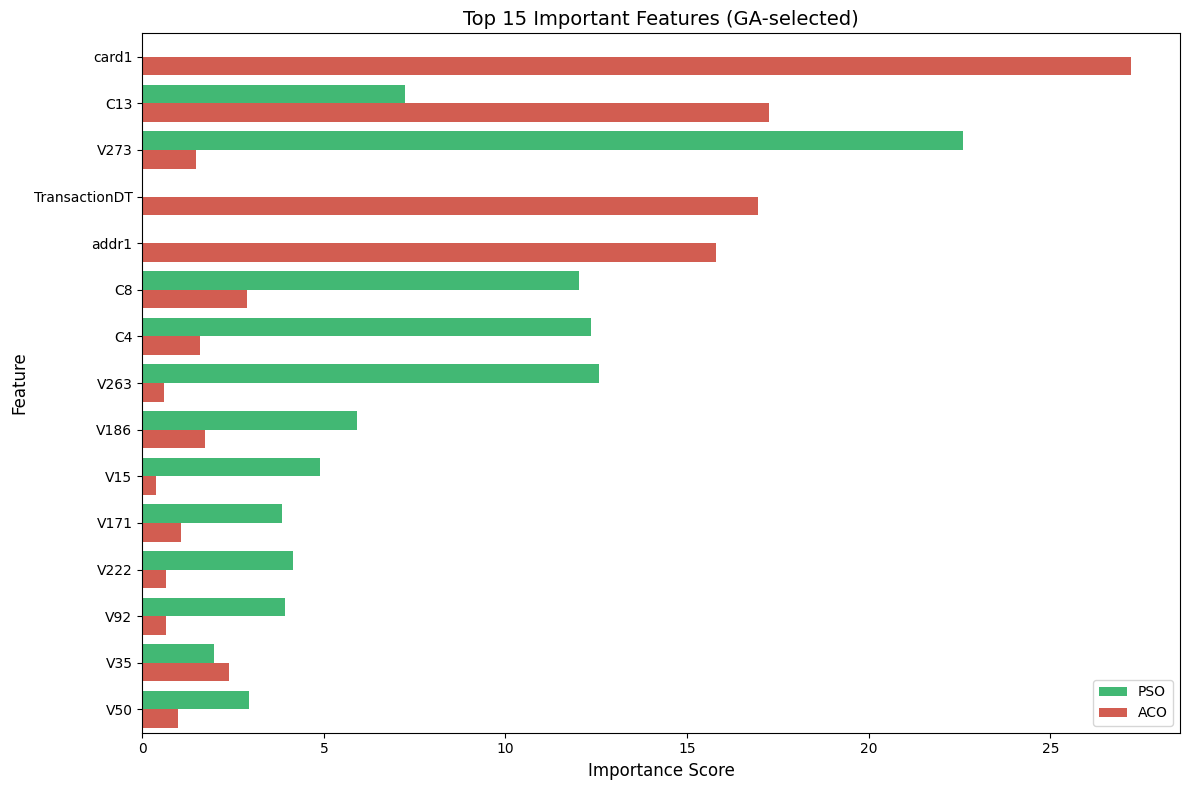


Top 10 Most Important GA-Selected Features:
      feature  pso_importance  aco_importance  avg_importance
        card1        0.004871       27.204238       13.604555
          C13        7.227826       17.247525       12.237675
         V273       22.579060        1.493604       12.036332
TransactionDT        0.000000       16.941037        8.470519
        addr1        0.000000       15.788518        7.894259
           C8       12.027329        2.884415        7.455872
           C4       12.355969        1.585918        6.970943
         V263       12.575959        0.603645        6.589802
         V186        5.905906        1.738615        3.822260
          V15        4.908579        0.384724        2.646651


In [34]:
import seaborn as sns
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train_ga.columns,
    'pso_importance': final_model_pso.get_feature_importance(),
    'aco_importance': final_model_aco.get_feature_importance()
})

# Sort by average importance
feature_importance['avg_importance'] = (feature_importance['pso_importance'] + 
                                       feature_importance['aco_importance']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Reshape for seaborn
plot_data = pd.melt(
    feature_importance, 
    id_vars=['feature'], 
    value_vars=['pso_importance', 'aco_importance'],
    var_name='model', 
    value_name='importance'
)
plot_data['model'] = plot_data['model'].map({'pso_importance': 'PSO', 'aco_importance': 'ACO'})

# Top 15 features
top_features = feature_importance.head(15)['feature'].tolist()
plot_data_top = plot_data[plot_data['feature'].isin(top_features)]

# Plot
sns.barplot(
    data=plot_data_top, 
    x='importance', 
    y='feature', 
    hue='model',
    palette=['#2ecc71', '#e74c3c']
)
plt.title('Top 15 Important Features (GA-selected)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='')
plt.tight_layout()
plt.show()

# Print the top features and their importance scores
print("\nTop 10 Most Important GA-Selected Features:")
print(feature_importance[['feature', 'pso_importance', 'aco_importance', 'avg_importance']].head(10).to_string(index=False))

### Compare PSO, ACO, and baseline results on GA-selected features

Now we'll do a comprehensive comparison of all three approaches: baseline CatBoost, PSO-optimized CatBoost, and ACO-optimized CatBoost, all using the same GA-selected features.

Evaluating models on GA-selected features:

Performance Comparison on GA-Selected Features:
     accuracy  precision  recall      f1     auc  avg_precision
PSO    0.9650     1.0000  0.0002  0.0005  0.7065         0.2223
ACO    0.9814     0.8998  0.5277  0.6652  0.9379         0.7269

Performance Comparison on GA-Selected Features:
     accuracy  precision  recall      f1     auc  avg_precision
PSO    0.9650     1.0000  0.0002  0.0005  0.7065         0.2223
ACO    0.9814     0.8998  0.5277  0.6652  0.9379         0.7269


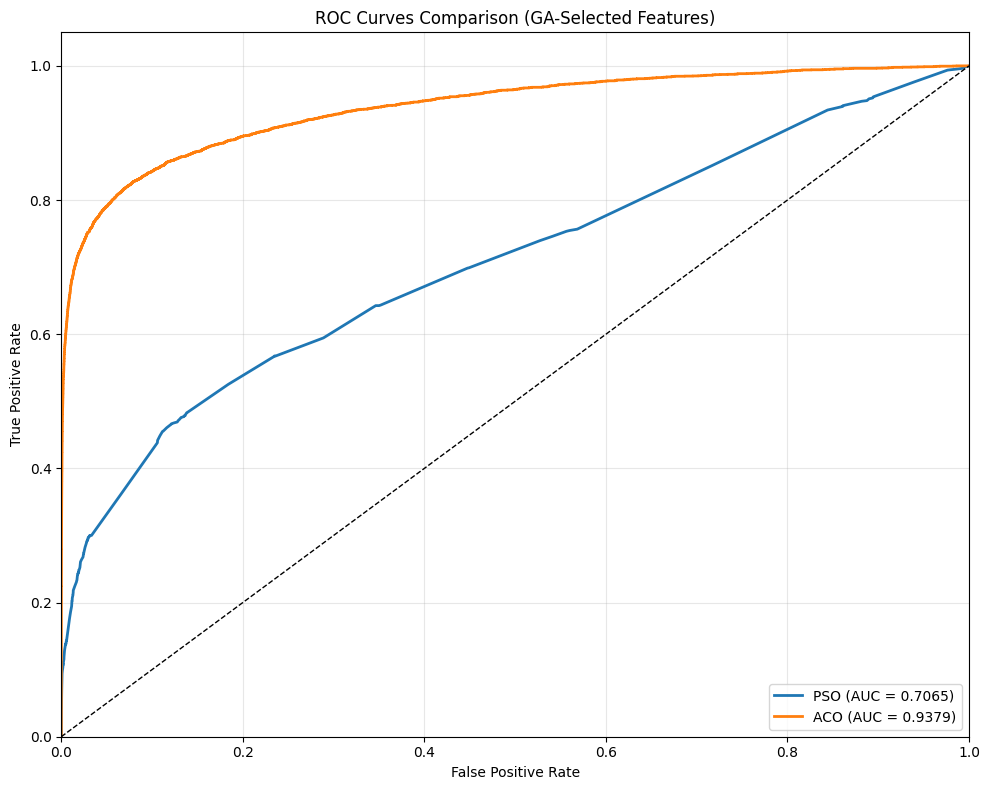

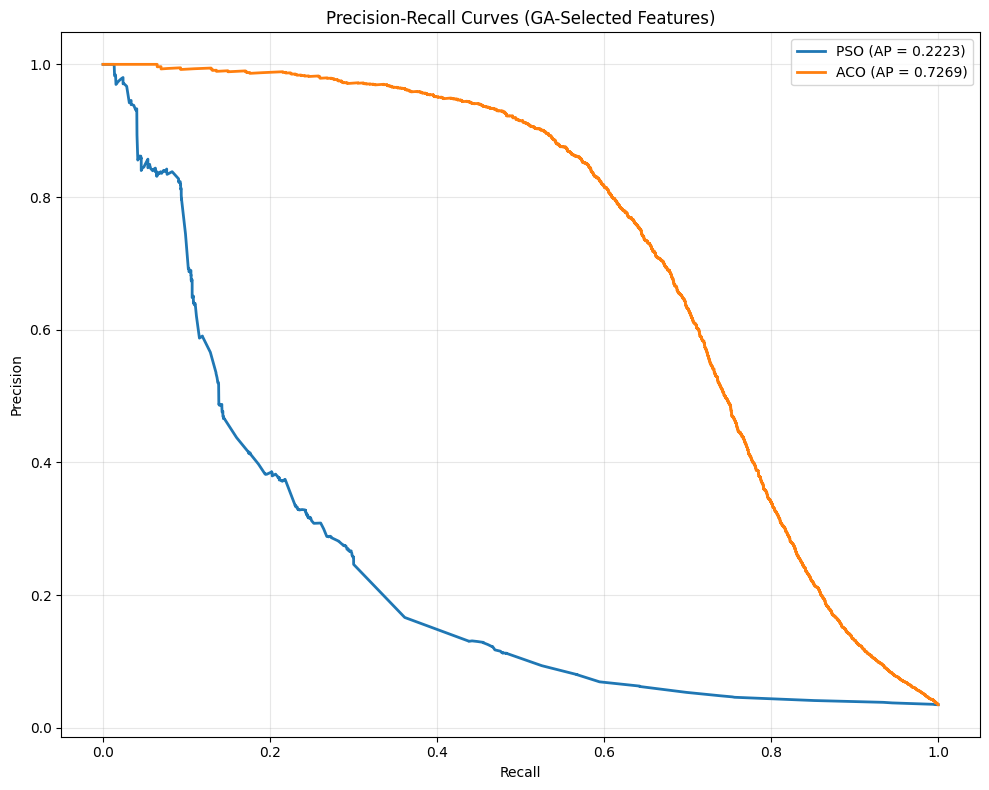


Improvement Summary on GA-Selected Features:

PSO vs Baseline:


TypeError: 'int' object is not subscriptable

In [38]:
from sklearn import metrics
import seaborn as sns

# Evaluate all three models
print("Evaluating models on GA-selected features:")

# Get predictions for all models
# y_pred_baseline = baseline_model_ga.predict(X_test_ga)
y_pred_pso = final_model_pso.predict(X_test_ga)
y_pred_aco = final_model_aco.predict(X_test_ga)

# y_pred_proba_baseline = baseline_model_ga.predict_proba(X_test_ga)[:, 1]
y_pred_proba_pso = final_model_pso.predict_proba(X_test_ga)[:, 1]
y_pred_proba_aco = final_model_aco.predict_proba(X_test_ga)[:, 1]

# Calculate metrics for all models
models = {
    # 'Baseline': (y_pred_baseline, y_pred_proba_baseline),
    'PSO': (y_pred_pso, y_pred_proba_pso),
    'ACO': (y_pred_aco, y_pred_proba_aco)
}

results = {}
for name, (y_pred, y_pred_proba) in models.items():
    results[name] = {
        'accuracy': metrics.accuracy_score(y_test, y_pred),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1': metrics.f1_score(y_test, y_pred),
        'auc': metrics.roc_auc_score(y_test, y_pred_proba),
        'avg_precision': metrics.average_precision_score(y_test, y_pred_proba)
    }

# Display results as a table
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)
print("\nPerformance Comparison on GA-Selected Features:")
print(comparison_df)

# ROC curves comparison
plt.figure(figsize=(10, 8))
for name, (_, y_pred_proba) in models.items():
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (GA-Selected Features)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, (_, y_pred_proba) in models.items():
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    avg_precision = metrics.average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (GA-Selected Features)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary of improvements
print("\nImprovement Summary on GA-Selected Features:")
baseline_metrics = 0 # results['Baseline']
for name in ['PSO', 'ACO']:
    print(f"\n{name} vs Baseline:")
    for metric, value in results[name].items():
        improvement = value - baseline_metrics[metric]
        improvement_pct = (improvement / baseline_metrics[metric]) * 100
        print(f"  {metric}: {improvement:.4f} absolute improvement ({improvement_pct:.2f}% relative improvement)")

### Prepare GA-selected features for final model deployment

Let's save the final optimized model and export the list of GA-selected features for future use. This ensures we can reproduce the exact same preprocessing pipeline when deploying the model.

In [39]:
# Determine the best model based on AUC score
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"The best model based on AUC is: {best_model_name}")

# Create a reference dictionary with GA feature indices and their names
ga_feature_mapping = {
    'indices': best_features,
    'names': selected_feature_names
}

# Export the GA feature information
import json
with open('ga_selected_features.json', 'w') as f:
    json.dump(ga_feature_mapping, f, indent=4)

# Save the best model
if best_model_name == 'PSO':
    best_model = final_model_pso
elif best_model_name == 'ACO':
    best_model = final_model_aco
else:
    best_model = baseline_model_ga

best_model.save_model('fraud_detection_best_model.cbm')

print(f"\nFinal model saved as 'fraud_detection_best_model.cbm'")
print(f"GA-selected features saved to 'ga_selected_features.json'")

# Function to preprocess and predict using the saved model
def predict_fraud(new_data, feature_mapping_path='ga_selected_features.json', model_path='fraud_detection_best_model.cbm'):
    """
    Predict fraud using the saved model and GA-selected features
    
    Args:
        new_data: DataFrame with the same columns as the original training data
        feature_mapping_path: Path to the saved GA feature mapping
        model_path: Path to the saved model
        
    Returns:
        Fraud predictions (1 for fraud, 0 for not fraud)
    """
    # Load feature mapping
    with open(feature_mapping_path, 'r') as f:
        feature_mapping = json.load(f)
    
    feature_names = feature_mapping['names']
    
    # Select only the GA-selected features
    if all(name in new_data.columns for name in feature_names):
        X_new = new_data[feature_names]
    else:
        indices = feature_mapping['indices']
        X_new = new_data.iloc[:, indices]
    
    # Load model and predict
    model = CatBoostClassifier()
    model.load_model(model_path)
    
    return model.predict(X_new)

print("\nCreated utility function 'predict_fraud()' for easy model deployment")

The best model based on AUC is: ACO

Final model saved as 'fraud_detection_best_model.cbm'
GA-selected features saved to 'ga_selected_features.json'

Created utility function 'predict_fraud()' for easy model deployment
